# Adding Noise to Input Image 

C:\Users\avnis\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


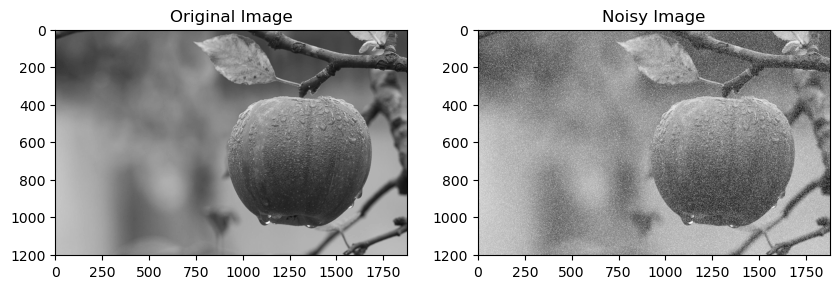

In [2]:
import numpy as np
import cv2
from PIL import Image 
from skimage import io
from matplotlib import pyplot as plt

# Generate a synthetic image for demonstration
image = io.imread(r'C:\Users\avnis\Downloads\spsd.jpg')

# Set the mean (mu) and standard deviation (sigma) for the Gaussian noise.
mu = 0
sigma = 1

# Generate Gaussian noise with the same dimensions as the image.
gaussian_noise = np.random.normal(mu, sigma, image.shape).astype(np.uint8)
noisy_image = cv2.add(image, gaussian_noise)#Add the Gaussian noise to the image
#Ensure that the noisy pixel values remain within the valid range (0 to 255 for an 8-bit image)
noisy_image = np.clip(noisy_image, 0, 255)

#original and noisy images
plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(image, cmap='gray'), plt.title('Original Image')
plt.subplot(122), plt.imshow(noisy_image, cmap='gray'), plt.title('Noisy Image')
plt.show()

# Adding Gaussian Blur to the Noised Image

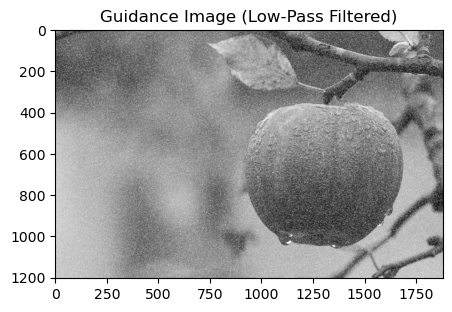

In [3]:

def gaussian_blur(image, sigma_s):
    kernel_size = 3
    blurred_image = cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma_s)
    return blurred_image

#standard deviation for the Gaussian blur
sigma_s = 3  

guidance_image = gaussian_blur(noisy_image.astype(np.uint8), sigma_s)

plt.figure(figsize=(5, 5))
plt.imshow(guidance_image, cmap='gray'), plt.title('Guidance Image (Low-Pass Filtered)')
plt.show()


# Applying Gaussian Adaptive Bilateral Filter to the Blur Image 

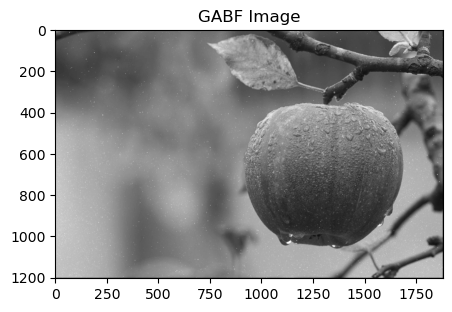

In [5]:

def bilateral_filter(image, guidance, sigma_s, sigma_r, window_size=3):
    """
    Apply a bilateral filter to an image.
    """
    half_window_size = window_size // 2
    filtered_image = np.zeros_like(image)

    # Iterate over each pixel in the image
    for i in range(half_window_size, image.shape[0] - half_window_size):
        for j in range(half_window_size, image.shape[1] - half_window_size):
            # Extract the local region
            i_min = i - half_window_size
            i_max = i + half_window_size + 1
            j_min = j - half_window_size
            j_max = j + half_window_size + 1

            local_image = image[i_min:i_max, j_min:j_max]
            local_guidance = guidance[i_min:i_max, j_min:j_max]

            # Initialize the kernel
            kernel = np.zeros((window_size, window_size), dtype=np.float32)

            # Compute the Gaussian spatial and range weights
            for m in range(window_size):
                for n in range(window_size):
                    di = i_min + m - i
                    dj = j_min + n - j
                    g_spatial = np.exp(-(di**2 + dj**2) / (2 * sigma_s**2))
                    g_range = np.exp(-((local_image[m, n] - local_guidance[m, n])**2) / (2 * sigma_r**2))
                    kernel[m, n] = g_spatial * g_range

            # Normalize the kernel and apply it
            kernel /= kernel.sum()
            filtered_value = np.sum(kernel * local_image)
            filtered_image[i, j] = filtered_value

    return filtered_image


# Define the standard deviation for the range kernel
sigma_r = 25.0  # The range standard deviation (can be adjusted)

# Apply the bilateral filter
gabf_image = bilateral_filter(noisy_image.astype(np.float32), guidance_image, sigma_s, sigma_r)

# Display the filtered image
plt.figure(figsize=(5, 5))
plt.imshow(gabf_image, cmap='gray'), plt.title('GABF Image')
plt.show()

# SNR of Filtered Image From GABF

In [9]:
def calculate_snr(original, noisy):
    signal_power = np.mean(original**2)
    noise_power = np.mean((original - noisy)**2)
    
    snr_db = 10 * np.log10(signal_power / noise_power)
    
    return snr_db


snr_gabf = calculate_snr(gabf_image,image)

# Filtering of Noised Image Through Bilateral Filter for comparision 

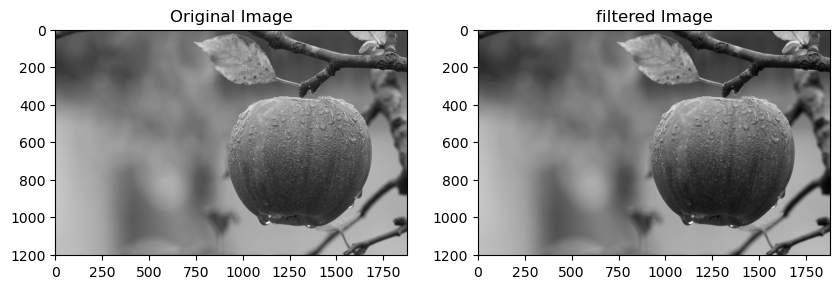

In [10]:
import cv2
import numpy as np

def bilateral_filter(image, d, sigma_color, sigma_space):
    filtered_image = cv2.bilateralFilter(image, d, sigma_color, sigma_space)
    return filtered_image

# Apply bilateral filter
filtered_image = bilateral_filter(image, d=9, sigma_color=25, sigma_space=25)

plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(image, cmap='gray'), plt.title('Original Image')
plt.subplot(122), plt.imshow(filtered_image, cmap='gray'), plt.title('filtered Image')
plt.show()

# SNR of Filtered Image From Bilateral Filter 

In [11]:
def calculate_snr(original, noisy):
    signal_power = np.mean(original**2)
    noise_power = np.mean((original - noisy)**2)
    
    snr_db = 10 * np.log10(signal_power / noise_power)
    
    return snr_db


snr_bilat = calculate_snr(filtered_image,image)

In [12]:
from tabulate import tabulate  # Import tabulate library


# Create a table for MSE and PSNR values
table_data = [
    ["Filter", "SNR"],
    ["GABF",f"{snr_gabf:.2f}"],
    ["Bilateral Filter",f"{snr_bilat:.2f}"]
]

# Print the table
print(tabulate(table_data, headers="firstrow", tablefmt="fancy_grid"))


╒══════════════════╤═══════╕
│ Filter           │   SNR │
╞══════════════════╪═══════╡
│ GABF             │ 23.01 │
├──────────────────┼───────┤
│ Bilateral Filter │  9.71 │
╘══════════════════╧═══════╛
